In [1]:
import os 
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

To explore time series models, we will continue with the Rossmann sales data. This dataset has sales data for sales at every Rossmann store for a 3-year period, as well indicators of holidays and basic store information.

In the last class, we saw that we would plot the sales data at a particular store to identify how the sales changed over time. Additionally, we computed autocorrelation for the data at varying lag periods. This helps us identify if previous timepoints are predictive of future data and which time points are most important - the previous day? week? month?

//anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


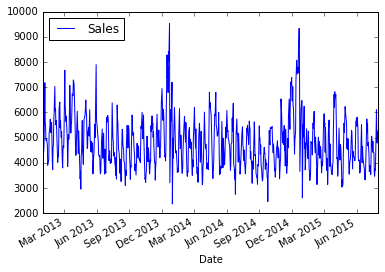

In [2]:
# Load the data and set the DateTime index
data = pd.read_csv('rossmann.csv', skipinitialspace=True)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Filter to Store 1
store1_data = data[data.Store == 1]

# Filter to open days
store1_open_data = store1_data[store1_data.Open==1]

# Plot the sales over time
store1_open_data[['Sales']].plot()

In [77]:
store1_open_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
Date,,,,,,,,
2015-07-31,1,5,5263,555,1,1,0,1
2015-07-30,1,4,5020,546,1,1,0,1
2015-07-29,1,3,4782,523,1,1,0,1
2015-07-28,1,2,5011,560,1,1,0,1
2015-07-27,1,1,6102,612,1,1,0,1


In [3]:
store1_open_data.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,781.0,781.000000,781.000000,781.000000,781.0,781.000000,781.000000
mean,1.0,3.504481,4759.096031,564.049936,1.0,0.448143,0.204866
std,0.0,1.714656,1012.106393,93.707476,0.0,0.497622,0.403862
min,1.0,1.000000,2362.000000,298.000000,1.0,0.000000,0.000000
25%,1.0,2.000000,4000.000000,500.000000,1.0,0.000000,0.000000
50%,1.0,3.000000,4647.000000,550.000000,1.0,0.000000,0.000000
75%,1.0,5.000000,5348.000000,612.000000,1.0,1.000000,0.000000
max,1.0,6.000000,9528.000000,1130.000000,1.0,1.000000,1.000000


**Check** Compute the autocorrelation of Sales in Store 1 for lag 1 and 2. Will we be able to use a predictive model - particularly an autoregressive one?

In [5]:
store1_open_data["Sales"].autocorr(lag = 1)

0.68269082422794292

In [6]:
store1_open_data["Sales"].autocorr(lag = 2)

0.48121726614607269

In [40]:
store1_data.Sales.autocorr(lag=1) # -0.12

-0.12732514339140213

In [41]:
store1_data.Sales.autocorr(lag=2) # -0.03

-0.034787155707946944

Pandas and statsmodels both provide convenience plots for autocorrelations.

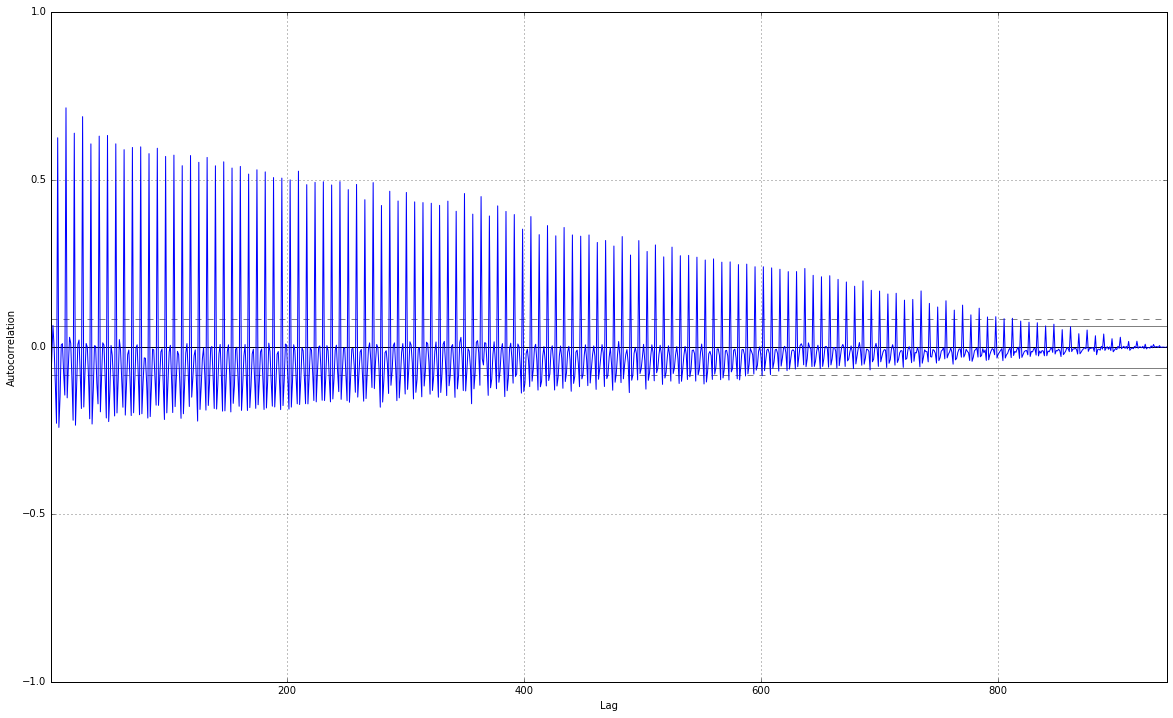

In [7]:
from pandas.tools.plotting import autocorrelation_plot
plt.figure(figsize=(20,12))

autocorrelation_plot(store1_data.Sales)

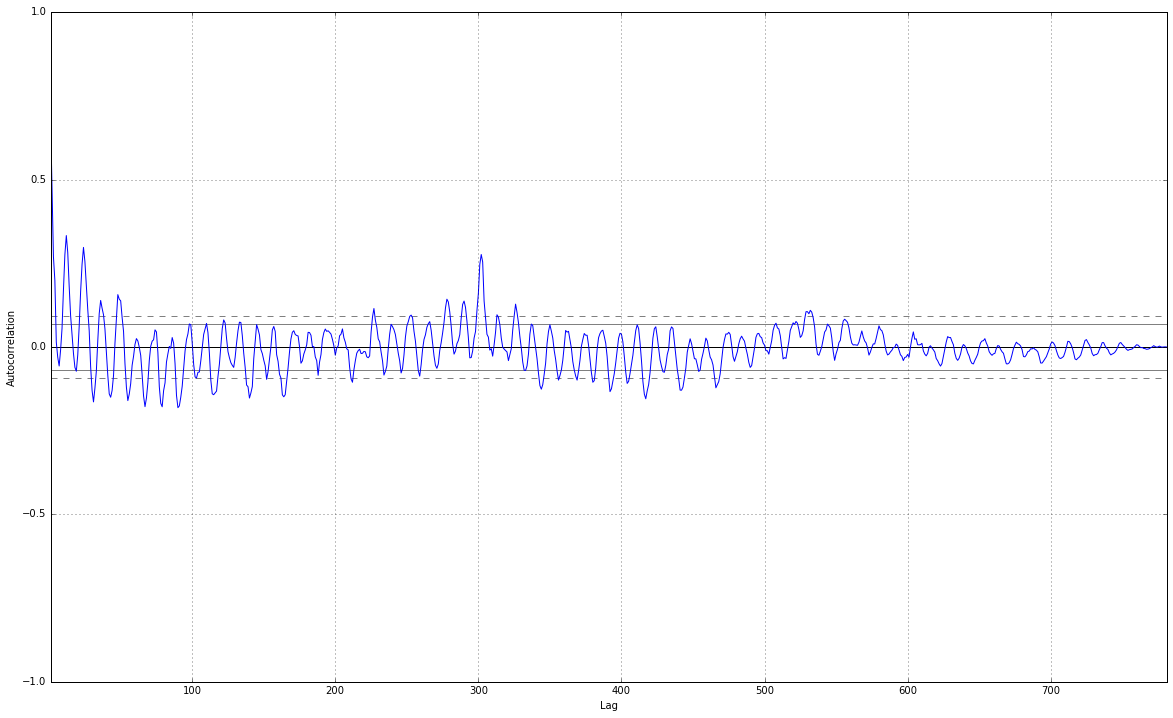

In [9]:
plt.figure(figsize=(20,12))

autocorrelation_plot(store1_open_data["Sales"])

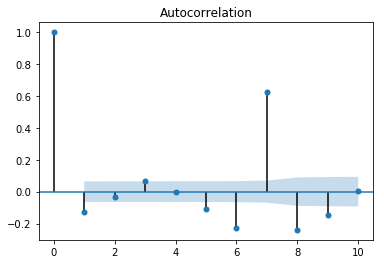

In [15]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(store1_data.Sales, lags=10)
plt.show()

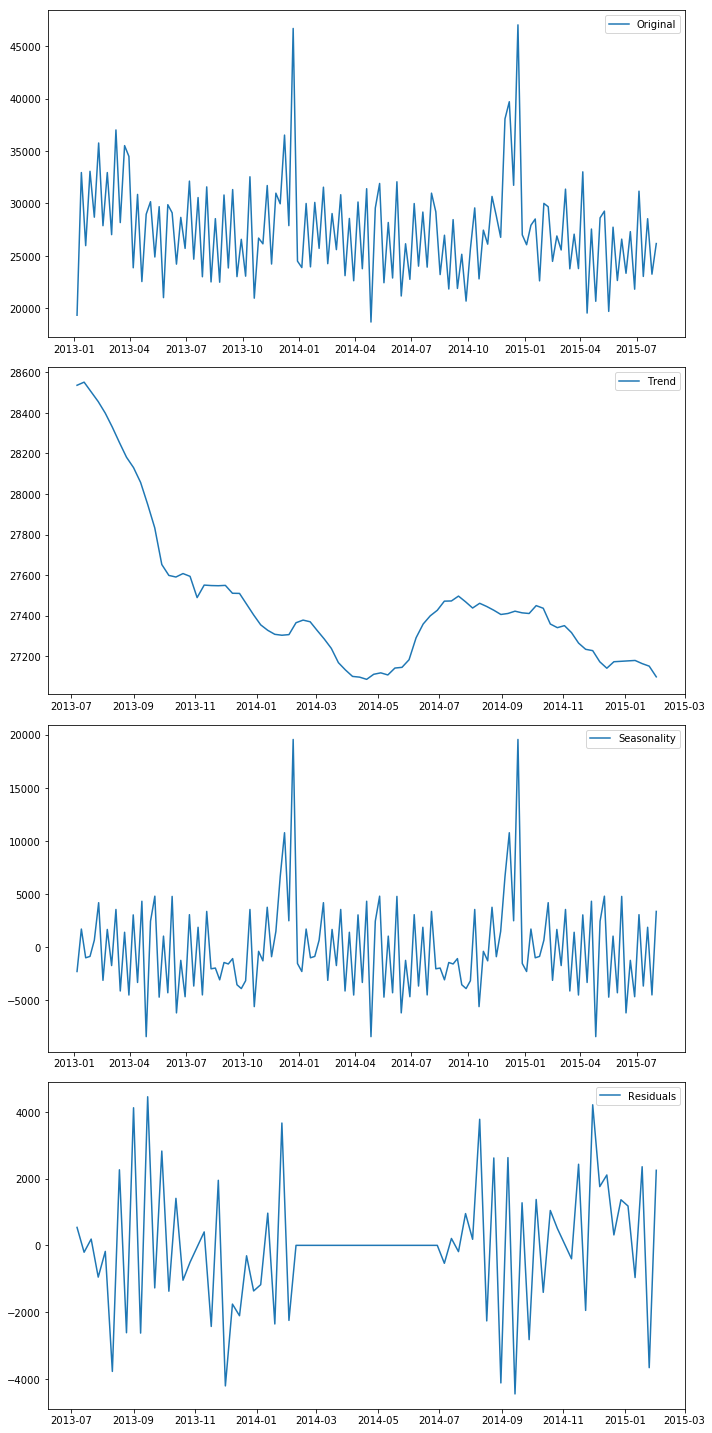

In [111]:
from statsmodels.tsa.seasonal import seasonal_decompose

daily = store1_open_data[['Sales']]

weekly_opendays = store1_data['Sales'].resample("W").sum()

X = weekly_opendays


#decomposition = seasonal_decompose(store1_data['Sales'])

decomposition = seasonal_decompose(X)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig = plt.figure(figsize=(10, 20)) 


plt.subplot(411)
plt.plot(X, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

**Check**: What caused the spike at 7?

# ARMA Model

Recall that `ARMA(p, q)` models are a sum of an `AR(p)` and a `MA(q)` model. So if we want just an `AR(p)` model we use and `ARMA(p, 0)` model. 

In [110]:
from statsmodels.tsa.arima_model import ARMA

store1_sales_data = store1_open_data[['Sales']].astype(float)

X1 = X.to_frame().astype(float)
model = ARMA(store1_sales_data, (1, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 0)   Log Likelihood               -6267.326
Method:                       css-mle   S.D. of innovations            739.079
Date:                Tue, 11 Apr 2017   AIC                          12540.651
Time:                        17:04:58   BIC                          12554.633
Sample:                    07-31-2015   HQIC                         12546.029
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4761.9579     82.984     57.384      0.000    4599.312    4924.604
ar.L1.Sales     0.6822      0.026     26.122      0.000       0.631       0.733
                                    Roots       

In [108]:
model = ARMA(store1_sales_data, (2, 0)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 0)   Log Likelihood               -6267.032
Method:                       css-mle   S.D. of innovations            738.800
Date:                Tue, 11 Apr 2017   AIC                          12542.063
Time:                        17:04:46   BIC                          12560.705
Sample:                    07-31-2015   HQIC                         12549.233
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.3980     85.262     55.856      0.000    4595.287    4929.509
ar.L1.Sales     0.6634      0.036     18.537      0.000       0.593       0.734
ar.L2.Sales     0.0275      0.036      0.767    

Just like with other types of regression, we can compute the model residuals.

**Check**: What are residuals? In linear regression, what did we expect of residuals?

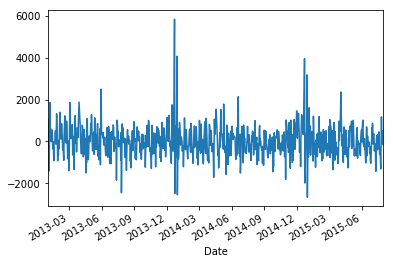

In [112]:
model.resid.plot()

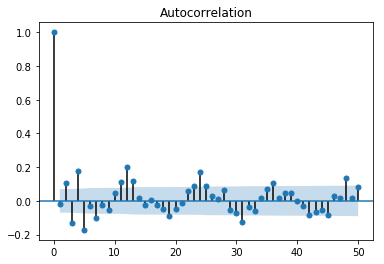

In [113]:
plot_acf(model.resid, lags=50)
plt.show()

Because of the errors, it doesn't look like an AR model is good enough -- the data aren't stationary. So let's expand to an `ARMA` model.

In [22]:
model = ARMA(store1_sales_data, (1, 1)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(1, 1)   Log Likelihood               -6267.111
Method:                       css-mle   S.D. of innovations            738.876
Date:                Tue, 11 Apr 2017   AIC                          12542.222
Time:                        13:23:09   BIC                          12560.865
Sample:                    07-31-2015   HQIC                         12549.392
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4762.7628     84.702     56.229      0.000    4596.749    4928.776
ar.L1.Sales     0.6979      0.035     20.095      0.000       0.630       0.766
ma.L1.Sales    -0.0294      0.045     -0.654    

In [24]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(store1_sales_data, (2, 0, 2)).fit()
print model.summary()

                              ARMA Model Results                              
Dep. Variable:                  Sales   No. Observations:                  781
Model:                     ARMA(2, 2)   Log Likelihood               -6243.725
Method:                       css-mle   S.D. of innovations            716.957
Date:                Tue, 11 Apr 2017   AIC                          12499.449
Time:                        13:23:33   BIC                          12527.413
Sample:                    07-31-2015   HQIC                         12510.204
                         - 01-02-2013                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4760.8482     75.651     62.931      0.000    4612.574    4909.122
ar.L1.Sales    -0.2277      0.056     -4.064      0.000      -0.338      -0.118
ar.L2.Sales     0.4689      0.057      8.271    

In [25]:
model = ARIMA(store1_sales_data, (2, 1, 2)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6247.179
Method:                       css-mle   S.D. of innovations            725.652
Date:                Tue, 11 Apr 2017   AIC                          12506.358
Time:                        13:23:34   BIC                          12534.314
Sample:                    07-30-2015   HQIC                         12517.111
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.5079      0.387      1.313      0.189      -0.250       1.266
ar.L1.D.Sales    -0.1820      0.050     -3.661      0.000      -0.279      -0.085
ar.L2.D.Sales     0.6469      0.035     

In [33]:
model = ARIMA(store1_sales_data, (2, 1, 0)).fit()
print model.summary()

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                  780
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -6313.493
Method:                       css-mle   S.D. of innovations            792.554
Date:                Tue, 11 Apr 2017   AIC                          12634.985
Time:                        13:24:21   BIC                          12653.622
Sample:                    07-30-2015   HQIC                         12642.153
                         - 01-02-2013                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.1303     23.604      0.006      0.996     -46.133      46.393
ar.L1.D.Sales    -0.1847      0.036     -5.155      0.000      -0.255      -0.114
ar.L2.D.Sales    -0.0178      0.036     

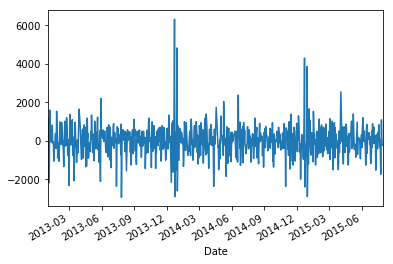

In [34]:
store1_sales_data.Sales.diff(1).autocorr(1) #-0.181

store1_sales_data.Sales.diff(1).plot()
plt.show()

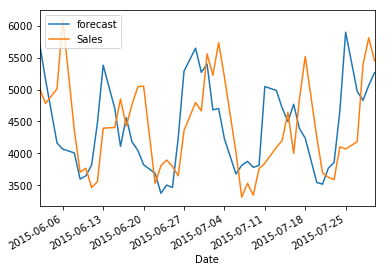

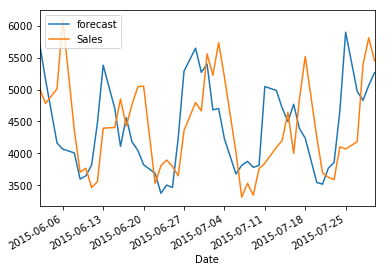

In [35]:
model.plot_predict(1, 50)

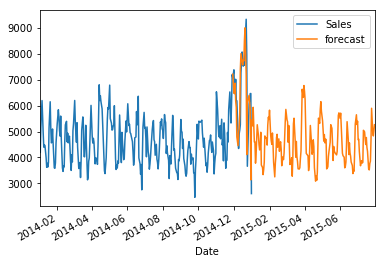

In [36]:
fig, ax = plt.subplots()
ax = store1_sales_data['2014'].plot(ax=ax)

fig = model.plot_predict(1, 200, ax=ax, plot_insample=False)

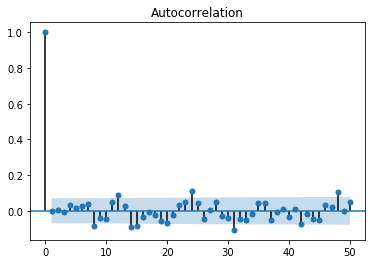

In [37]:
model = ARIMA(store1_sales_data, (7, 1, 2)).fit()
model.summary()

plot_acf(model.resid, lags=50)
plt.show()